## CNN

EEC 270 Website Fingerprinting

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
# sns.set_style('whitegrid')
# sns.set_palette('Set2')

data = pd.read_csv('data_5.csv')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 2),
            nn.ReLU(),
            nn.MaxPool2d(1, 1),
            
            nn.Conv2d(8, 16, 2),
            nn.ReLU(),
            # nn.MaxPool2d(1, 1),
        )
        self.linear = nn.Sequential(
            nn.Linear(144, 72),
            nn.BatchNorm1d(72),
            nn.LeakyReLU(),
            
            nn.Linear(72, 31),
            nn.BatchNorm1d(31),
            nn.LeakyReLU(),
        )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = output.view(output.size(0), -1)
        return self.linear(output)

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import random

BATCH_SIZE = 200

X, y = data.values[:,:-1], data.values[:,-1]
X, y = torch.Tensor(X), torch.Tensor(y)
trans_X = X.reshape((len(X), 1, 5, 5))
trans_X_ = X.reshape((5, len(X), 5))
X = trans_X

dataset = TensorDataset(X, y)
loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Split dataset into train and valid, with a ratio of 4:1
dataset_size = len(dataset)
indices = list(range(dataset_size))
random.shuffle(indices)
split = int(np.floor(0.2 * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
valid_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_sampler
)

X_test, y_test = None, None
for _, test_sample in enumerate(valid_loader):
    X_test, y_test = test_sample[0], test_sample[1].long()


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./cnn')

model = CNN()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(5000):
    for _, sample in enumerate(train_loader, 0):
        model.zero_grad()
        inputs, labels = sample
        labels = labels.long()
        pred = model(inputs)
        
        # Training loss
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
    
    correct, total = 0, 0
    with torch.no_grad():
        for sample in valid_loader:
            inputs, labels = sample
            labels = labels.long()
            pred = model(inputs)
            
            _, predicted = torch.max(pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    writer.add_scalar('Loss/train', loss.item(), epoch)
    writer.add_scalar('Accuracy/test', correct/total, epoch)
        
    if epoch % 100 == 0:
        print('Epoch', epoch, 'Training Loss:', loss.item(), 'Accuracy:', correct/total)

Epoch 0 Training Loss: 3.402883768081665 Accuracy: 0.03005008347245409
Epoch 100 Training Loss: 1.7720423936843872 Accuracy: 0.6477462437395659
Epoch 200 Training Loss: 1.4352009296417236 Accuracy: 0.7111853088480802
Epoch 300 Training Loss: 1.1173481941223145 Accuracy: 0.7696160267111853
Epoch 400 Training Loss: 1.2116858959197998 Accuracy: 0.7829716193656093
Epoch 500 Training Loss: 0.9402410984039307 Accuracy: 0.7996661101836394
Epoch 600 Training Loss: 0.9204897880554199 Accuracy: 0.8096828046744574
Epoch 700 Training Loss: 0.747073769569397 Accuracy: 0.8113522537562604
Epoch 800 Training Loss: 0.8344688415527344 Accuracy: 0.8146911519198664
Epoch 900 Training Loss: 0.812929093837738 Accuracy: 0.8146911519198664
Epoch 1000 Training Loss: 0.8196234703063965 Accuracy: 0.8230383973288815
Epoch 1100 Training Loss: 0.7112202048301697 Accuracy: 0.8130217028380634
Epoch 1200 Training Loss: 0.7237445116043091 Accuracy: 0.8213689482470785
Epoch 1300 Training Loss: 0.7327423095703125 Accurac

In [8]:
pred = model(X_test)
accuracy_score(pred.argmax(axis=1), y_test)

0.8743718592964824

Text(0.5, 1.0, 'Softmax Distribution vs. Labels for Sample 0')

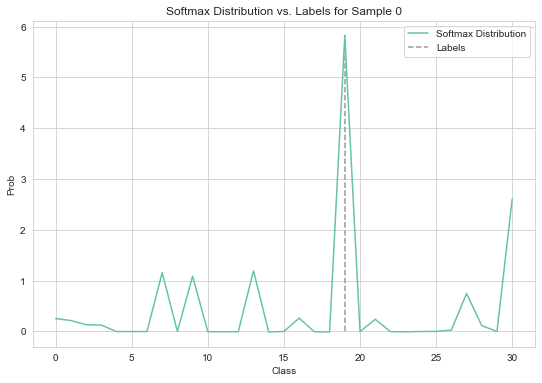

In [44]:
plt.figure(figsize=(9, 6))
plt.xlabel('Class')
plt.ylabel('Prob')
plt.vlines(y_test[0], 0, pred[0].max(), linestyles='dashed', colors='.6', label='Labels')
plt.plot(pred[0].cpu().detach().numpy())
plt.legend(['Softmax Distribution', 'Labels'])
plt.title('Softmax Distribution vs. Labels for Sample 0')

In [ ]:
plt.figure(figsize=(9, 6))
plt.xlabel('Class')
plt.ylabel('Prob')
plt.vlines(y_test[0], 0, pred[0].max(), linestyles='dashed', colors='.6', label='Labels')
plt.plot(pred[0].cpu().detach().numpy())
plt.legend(['Softmax Distribution', 'Labels'])
plt.title('Softmax Distribution vs. Labels for Sample 0')

In [62]:
import joblib
joblib.dump(model, 'cnn.pkl')

['cnn.pkl']

In [20]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(50, 100), random_state=0, max_iter=1000, activation='relu')

X, y = data.values[:,:-1], data.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
NN.fit(X_train, y_train)
print(accuracy_score(NN.predict(X_test), y_test))


0.625


In [43]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0).fit(X_train, y_train)
accuracy_score(RF.predict(X_test), y_test)

0.8683333333333333

In [54]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver='newton-cg', multi_class='multinomial', random_state=0)
LR.fit(X_train, y_train)
print(accuracy_score(LR.predict(X_test), y_test))

0.8016666666666666


In [70]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=3)
kNN.fit(X_train, y_train)
accuracy_score(kNN.predict(X_test), y_test)

0.81